In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
import random

In [2]:
rcParams['figure.figsize'] = [15, 15]
rcParams['font.size'] = 24
rcParams['axes.labelsize'] = 28
rcParams['axes.labelpad'] = 15

In [3]:
# Define the wavefunction
def wavefunctions(x, alpha=1, **kwargs):
    return np.exp( -alpha * x**2 )

# Define the probability corresponding to the wavefunction
def wavefunction_prob(x, alpha=1, **kwargs):
    return np.exp( -2 * alpha * x * x)

def ln_prob(x, alpha=1, **kwargs):
    return -2 * alpha * x * x

In [4]:
# General MCMC to sample from a probability distribution given some set of initial positions of walkers
# Takes in a list of functions to evaluate at each iteration of the MCMC
# For QMC, these functions are the observables we wish to measure 
def mcmc(prob, initial_location, draw, funcs=[], num_iter=10000, log=False, **kwargs):
    results = [[] for i in range(len(funcs))]
    
    location = initial_location
    
    locations = []
    
    for i in range(num_iter):
        for j, func in enumerate(funcs):
            results[j].append(func(location, **kwargs))
        
        # Record where we are
        prev_prob = prob(location, **kwargs)
        
        # Propose update
        next_location = draw(location, **kwargs)
        next_prob = prob(next_location, **kwargs)
        
        if type(location) == np.ndarray:
            if log:
                where_to_update = np.log(np.random.uniform(0, 1, len(initial_location)))
                move = np.where(next_prob - prev_prob > where_to_update)
            else:
                where_to_update = np.random.uniform(0, 1, len(initial_location))
                move = np.where(next_prob / prev_prob > where_to_update)
            
            # Accept update
            location[move] = next_location[move]
        else:
            if log:
                if next_prob - prev_prob > math.log(random.uniform(0, 1)):
                    # Accept update
                    location = next_location
            else:
                if next_prob / prev_prob > random.uniform(0, 1):
                    # Accept update
                    location = next_location
        
        locations.append(np.copy(location))
        
    return np.array(locations), np.array(results)

In [5]:
# Function to draw new set of parameters
# Parameters are drawn uniformly from the space around
# their current locations
def draw(x, eps=0.1, **kwargs):
    if type(x) == np.ndarray:
        return np.random.uniform(x - eps, x + eps, len(x))
    else:
        return random.uniform(x - eps, x + eps)

In [6]:
# The local energy of the walkers
def get_energy(x, alpha=1, **kwargs):
    return alpha + x**2 * (0.5 - 2 * alpha**2)

In [7]:
avg_energies = []
avg_square_energies = []

alphas = np.linspace(0.10, 1.8, 40)

num_walkers = 2000

for i, alpha in enumerate(alphas):
    _, result = mcmc(ln_prob, np.random.uniform(-1, 1, size=num_walkers), draw, log=True, funcs=[get_energy], num_iter=10000, alpha=alpha, eps=0.1)
    avg_energies.append(np.mean(result[0]))
    avg_square_energies.append(np.mean(result[0]**2))
    
    print("{:0.1f}% done       \r".format(100 * (i + 1) / len(alphas)), end='')

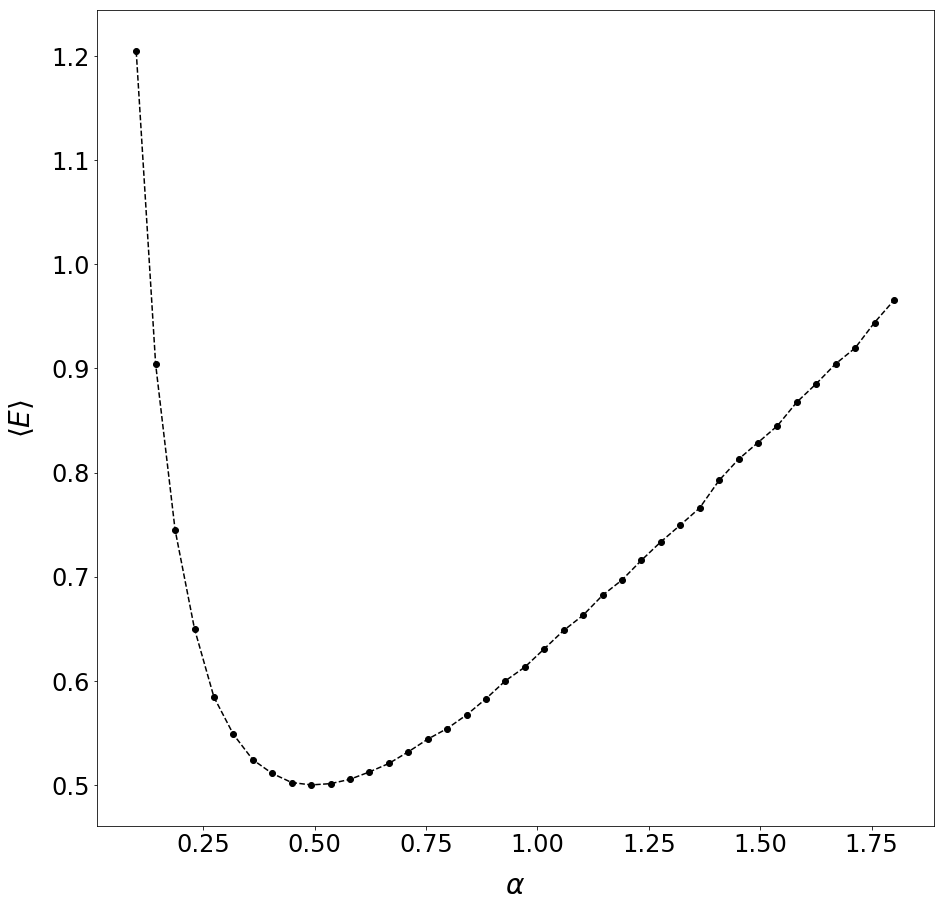

In [8]:
plt.scatter(alphas, avg_energies, color='k')
plt.plot(alphas, avg_energies, color='k', linestyle='--')

plt.xlabel(r'$\alpha$')
plt.ylabel(r"$\langle E \rangle$")

plt.show()

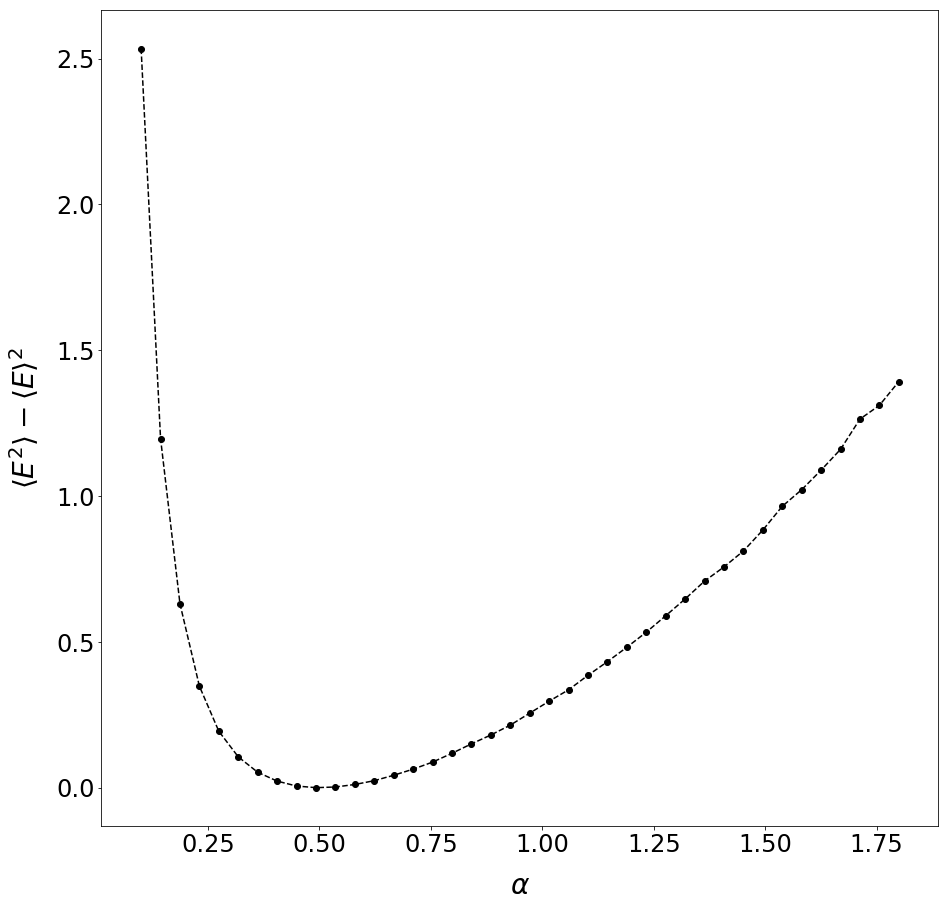

In [9]:
plt.xlabel(r'$\alpha$')
plt.ylabel(r"$\langle E^2 \rangle - \langle E \rangle^2$")

plt.scatter(alphas, np.array(avg_square_energies) - np.array(avg_energies)**2, color='k')
plt.plot(alphas, np.array(avg_square_energies) - np.array(avg_energies)**2, color='k', linestyle='--')

plt.show()

## Optimize $\alpha$

$$
\frac{d\langle E_L \rangle}{d \alpha} = 2 \left( \langle E_L \frac{d \ln \psi}{d \alpha} \rangle - \langle E_L \rangle \langle \frac{d \ln\psi}{d\alpha} \rangle \right)
$$

$$
\alpha^{\left(n+1\right)} = \alpha^{\left( n \right)} - \gamma \frac{d \langle E_L \rangle }{d \alpha}
$$

In [10]:
def update_alpha(alpha, gamma, deriv):
    return alpha - gamma * deriv

In [11]:
# Number of iterations to optimize alpha for
n_iter = 100
# Damping factor for gradient descent
gamma = 0.05

# Number of walkers for VMC
num_walkers = 1000

# Original alpha value
alpha = 0.7
alphas_opt = [alpha]

for i in range(n_iter):
    # Run MCMC and get energies
    chain, result = mcmc(ln_prob, np.random.uniform(-1, 1, size=num_walkers), draw, log=True, funcs=[get_energy], num_iter=10000, alpha=alpha, eps=0.1)
    energy = result[0]
    # Compute derivative of local energy w.r.t. alpha
    deriv = 2 * ( np.mean(- np.array(chain)**2 * energy ) - np.mean(energy) * np.mean(- np.array(chain)**2) )
    # Update alpha in accordance with update rule
    alpha = update_alpha(alpha, gamma, deriv)
    alphas_opt.append(alpha)
        
    print("{:0.1f}% done       \r".format(100 * (i + 1) / n_iter), end='')

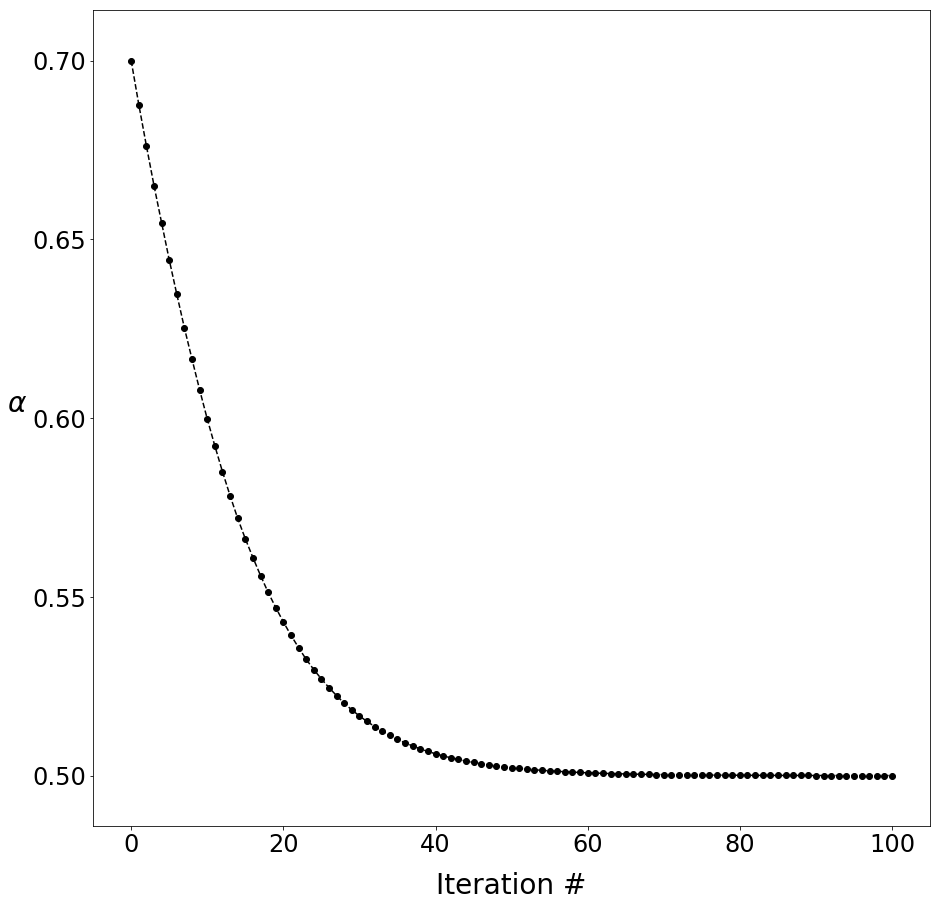

In [12]:
plt.scatter(np.arange(len(alphas_opt)), alphas_opt, color='k')
plt.plot(np.arange(len(alphas_opt)), alphas_opt, color='k', linestyle='--')

plt.ylabel(r"$\alpha$", rotation=0)
plt.xlabel("Iteration #")

plt.show()

# Part 2

In [13]:
def DMC(walkers, delta_tau, E_t, alpha, M_t, num_iter=100):
    for i in range(num_iter):
        num_walkers = len(walkers)
        
        # Move the walkers randomly
        walkers += math.sqrt(delta_tau) * np.random.normal(size=(num_walkers, 3))

        # Compute the potential at every walker position
        V = np.linalg.norm(walkers, axis=1)**2 / 2
        
        # Figure out which walkers should die, which should stay, and which should clone themselves
        W = np.exp(delta_tau * (E_t - V))
        s = np.floor(W).astype(int)
        r = np.random.uniform(size=len(s))
        
        update = np.where(r < W - s)
        s[update] = s[update] + 1

        stay = np.where(s > 0)

        more = np.where(s > 1)[0]

        # Clone walkers that need to be cloned
        new_walkers = []
        for idx in more:
            num_new_walkers = s[idx] - 1
            for j in range(num_new_walkers):
                new_walkers.append(walkers[idx].copy())

        # If we have new walkers, add them to the assortment
        if len(new_walkers) != 0:
            walkers = np.concatenate((walkers[stay], new_walkers))
        else:
            walkers = walkers[stay]

        # Update energy and keep going if we still have walkers
        if len(walkers) > 0:
            E_t = E_t + alpha * np.log(M_t / len(walkers))
        else:
            print("Out of walkers!")
            break
            
    return walkers

In [14]:
# Random assortment of walkers within unit ball
walkers = np.random.uniform(-1, 1, size=(10000, 3))
# Imaginary time discretization
delta_tau = 0.01
# Target energy (guess)
E_t = 1
# Small number to change how much target energy changes
alpha = 0.01
# Target number of walkers
M_t = 1e5

# Run Diffusion Monte Carlo with above parameters
res_walkers = DMC(walkers, delta_tau, E_t, alpha, M_t, num_iter=500)

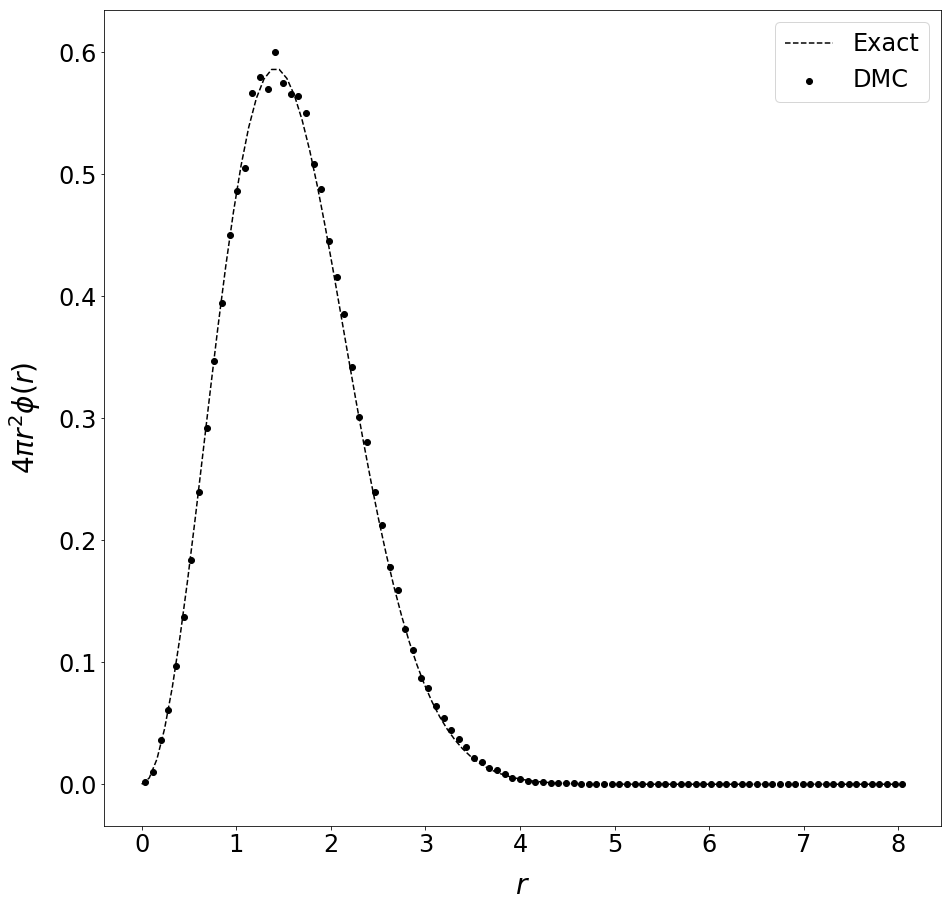

In [15]:
heights, bins, _ = plt.hist(np.linalg.norm(res_walkers, axis=1), bins=100, range=(0, 8), normed=True, align='mid')
plt.close()
r = np.linspace(0, 8, 100)
plt.scatter(r + (bins[1] - bins[0])/2, heights, color='k', label='DMC')
plt.plot(r, 4 * np.pi * r**2 * np.exp(- r**2 / 2) / (2* np.pi)**(3/2), color='k', linestyle='--', label='Exact')

plt.xlabel(r"$r$")
plt.ylabel(r"$4\pi r^2 \phi\left(r\right)$")

plt.legend()
plt.show()